# **Implementation of ANN Lagaris**




In [ ]:
# Importing Module

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import e
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Parameters

In [ ]:
lr = 0.005

In [ ]:
# Loss Function

In [ ]:
def first_order_loss(neural_network, trial_solution, given_diff,  domain_lower_bound=0, domain_upper_bound=1, num_points=10):

    delta = 1e-5
    x = torch.linspace(domain_lower_bound, domain_upper_bound, num_points, requires_grad=True).unsqueeze(1)
    dtrial_dx = (trial_solution(neural_network, x+delta) - trial_solution(neural_network, x)) / delta
    individual_error = (dtrial_dx - given_diff(x, trial_solution, neural_network))**2

    return torch.sum(individual_error)

In [ ]:
def second_order_loss(neural_network, trial_solution, given_diff,  domain_lower_bound=0, domain_upper_bound=1, num_points=10):

    delta = 1e-3
    x = torch.linspace(domain_lower_bound, domain_upper_bound, num_points, requires_grad=True).unsqueeze(1)
    dtrial_dx = (trial_solution(neural_network, x+delta) - trial_solution(neural_network, x)) / delta
    d2trial_dx2 = (trial_solution(neural_network, x+delta) - 2*trial_solution(neural_network, x) + trial_solution(neural_network, x-delta))/(delta**2)
    individual_error = (d2trial_dx2 - given_diff(x, dtrial_dx, trial_solution, neural_network))**2

    return torch.sum(individual_error)

In [ ]:
# Defining Neural Network

In [ ]:
class Network(nn.Module):
  def __init__(self, input, hidden = 16, output = 1, activation = "sigmoid"):
    super().__init__()
    self.hidden = nn.Linear(input, hidden)
    self.output = nn.Linear(hidden, output)
    self.act = activation
  def forward(self, x):
    if self.act == "sigmoid":
      x = F.sigmoid(self.hidden(x))
    elif self.act == "relu":
      x = F.relu(self.hidden(x))
    elif self.act == "tanh":
      x = F.tanh(self.hidden(x))
    elif self.act == "lrelu":
      x = F.leaky_relu(self.hidden(x))
    x = self.output(x)
    return x

In [ ]:
# Train function

In [ ]:
def train(network, loss_function, trial_solution, given_diff, epochs, display_step = 10, domain_lower_bound=0, domain_upper_bound=1, num_points=10):
  optimizer = optim.Adam(network.parameters(), lr = lr  )
  for epoch in range(epochs):
    optimizer.zero_grad()

    # Compute the loss
    loss = loss_function(network, trial_solution, given_diff, domain_lower_bound, domain_upper_bound, num_points)

    # Backpropagate
    loss.backward()

    # Adjust model parameters accordingly
    optimizer.step()

    if epoch % display_step == 0:
        print("epoch: {}, loss: {}".format(epoch, loss.item()))

In [ ]:
def visulaize(train_solution, network, domain_lb = 0, domain_ub = 1, points = 100, original_fun = None):
  x = torch.linspace(domain_lb, domain_ub, points).unsqueeze(1)
  y_approx = train_solution(network, x).squeeze(0).detach().numpy().transpose()[0]

  if original_fun:
    fig, axis = plt.subplots(2,1, figsize = (10,10), sharex=True)
    y_original = original_fun(x).squeeze(0).detach().numpy().transpose()[0]
    x = x.squeeze(0).detach().numpy().transpose()[0]
    axis[0].plot(x,y_approx,  label = "Approximation")
    axis[0].plot(x,y_original, label = "Exact")
    axis[1].plot(x, y_original- y_approx, label = "Residual")
    axis[0].legend()
    axis[1].legend()
  else:
    x = x.squeeze(0).detach().numpy().transpose()[0]
    plt.plot(x,y_approx, label = "Approximation")
    plt.legend()
  plt.show()


# Example 1
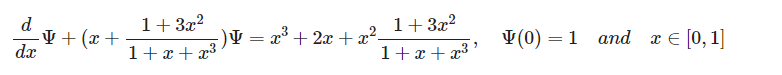

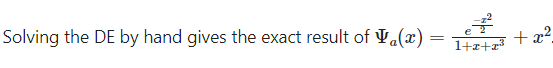

In [ ]:
exp1_sigm = Network(1, hidden = 128)
exp1_relu = Network(1, hidden = 128, activation = "relu")
exp1_tanh = Network(1, hidden = 128, activation = "tanh")
exp1_leakyrelu = Network(1, hidden = 128, activation = "lrelu")

In [ ]:
# Initializing necessary function

In [ ]:
def trial_solution(neural_network, x):
    result = 1 + x * neural_network(x)
    return result
def given_diff(x, trial_solution, neural_network):
  return x**3 + 2*x + (x**2)*((1+3*x**2)/(1+x+x**3)) - trial_solution(neural_network, x)*(x + ((1+3*(x**2))/(1+x+x**3)))
def original_function(x):
    return ((torch.exp(-(x**2)/2)/(1+x+x**3))+x**2)

In [ ]:
train(exp1_sigm, first_order_loss, trial_solution, given_diff, 6001, 600)

epoch: 0, loss: 6.627352714538574
epoch: 600, loss: 0.028896110132336617
epoch: 1200, loss: 0.013382802717387676
epoch: 1800, loss: 0.009157090447843075
epoch: 2400, loss: 0.006099269725382328
epoch: 3000, loss: 0.00492202490568161
epoch: 3600, loss: 0.005869576241821051
epoch: 4200, loss: 0.004204938653856516
epoch: 4800, loss: 0.004397828131914139
epoch: 5400, loss: 0.016092654317617416
epoch: 6000, loss: 0.004514538682997227


In [ ]:
lr = 0.0005
train(exp1_relu, first_order_loss, trial_solution, given_diff, 6001, 600)

epoch: 0, loss: 55.16410446166992
epoch: 600, loss: 0.019549377262592316
epoch: 1200, loss: 0.0026121109258383512
epoch: 1800, loss: 0.0018291366286575794
epoch: 2400, loss: 0.0005643905024044216
epoch: 3000, loss: 0.0006099361926317215
epoch: 3600, loss: 0.0004457073810044676
epoch: 4200, loss: 0.001142823719419539
epoch: 4800, loss: 0.0005438611260615289
epoch: 5400, loss: 0.0008590116631239653
epoch: 6000, loss: 0.00043595238821581006


In [ ]:
train(exp1_leakyrelu, first_order_loss, trial_solution, given_diff, 6001, 600)

epoch: 0, loss: 21.499401092529297
epoch: 600, loss: 0.0047121066600084305
epoch: 1200, loss: 0.0029590046033263206
epoch: 1800, loss: 0.0005857306532561779
epoch: 2400, loss: 0.00023545543081127107
epoch: 3000, loss: 0.00010789538646349683
epoch: 3600, loss: 0.0003615571476984769
epoch: 4200, loss: 0.00021381904662121087
epoch: 4800, loss: 0.0001854495785664767
epoch: 5400, loss: 0.00024759865482337773
epoch: 6000, loss: 0.0007802042528055608


In [ ]:
lr = 0.005
train(exp1_tanh, first_order_loss, trial_solution, given_diff, 6001, 600)

epoch: 0, loss: 10.030580520629883
epoch: 600, loss: 0.0070446874015033245
epoch: 1200, loss: 0.011628529988229275
epoch: 1800, loss: 0.003312288084998727
epoch: 2400, loss: 0.0012211677385494113
epoch: 3000, loss: 0.005725056864321232
epoch: 3600, loss: 0.008045836351811886
epoch: 4200, loss: 0.00349787506274879
epoch: 4800, loss: 0.000853802019264549
epoch: 5400, loss: 0.00151831132825464
epoch: 6000, loss: 0.000963173748459667


In [ ]:
# I have tried to learn nn with different params (activation functio, number of hidden layer and learning rate)
# What i have find out :-
# As this is a  single layer nn , loss function is not gratly affected be the type of activation function choosen
# But as number of hiddent unit in a single layer , complexity of the model increases and relu and leaky relu starts to performs in less number of epochs compare to the sigmoid and tanh
# Second thing which is consisitent, tanh performs better campare to the sigmoid activation function as tanh produces zero centerd data
# Similiarly leaky relu solve the problem of dying relu so it performs better compare to relu

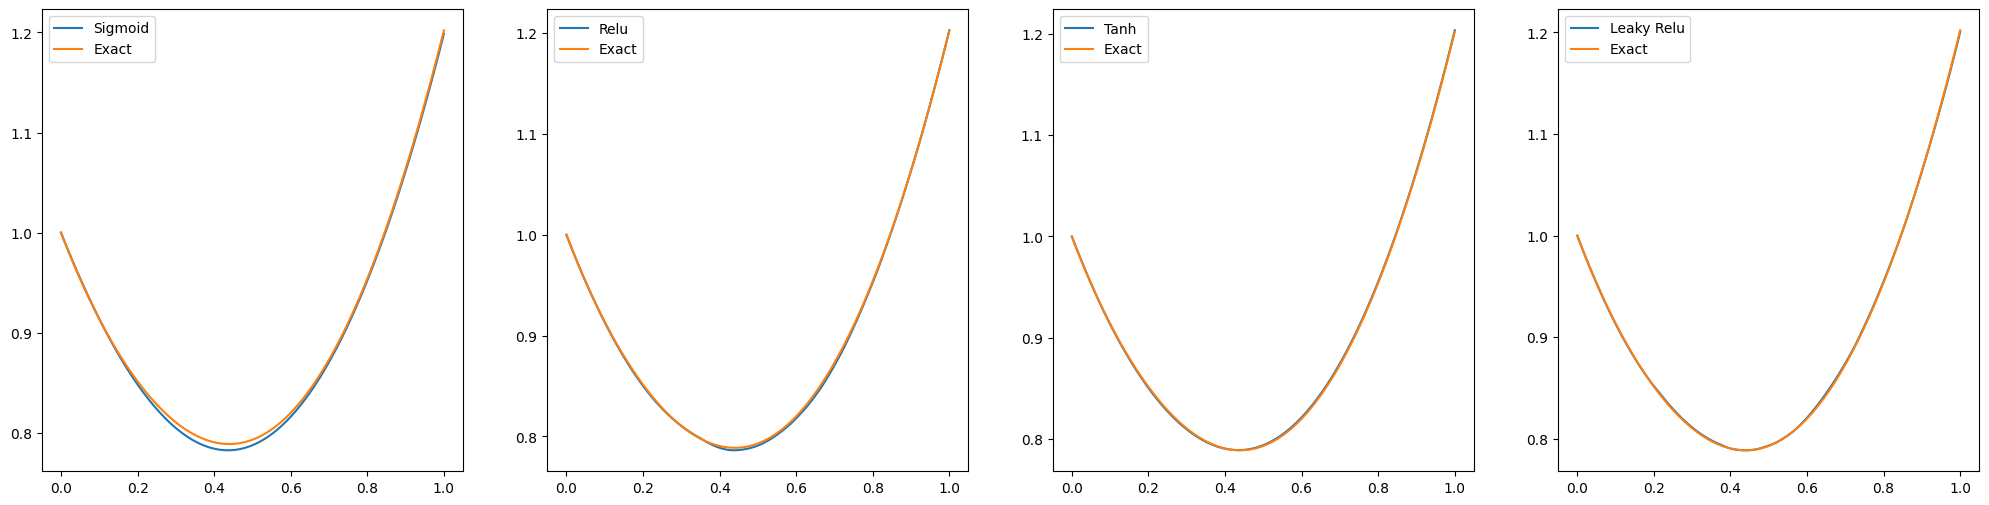

In [ ]:
x = torch.linspace(0, 1, 100).unsqueeze(1)
y_exp1_sigm = trial_solution(exp1_sigm, x).squeeze(0).detach().numpy().transpose()[0]
y_exp1_tanh = trial_solution(exp1_tanh, x).squeeze(0).detach().numpy().transpose()[0]
y_exp1_relu = trial_solution(exp1_relu, x).squeeze(0).detach().numpy().transpose()[0]
y_exp1_leakyrelu = trial_solution(exp1_leakyrelu, x).squeeze(0).detach().numpy().transpose()[0]

fig, axis = plt.subplots(1,4, figsize = (25,6), sharex=True)
y_original = original_function(x).squeeze(0).detach().numpy().transpose()[0]
x = x.squeeze(0).detach().numpy().transpose()[0]
axis[0].plot(x,y_exp1_sigm,  label = "Sigmoid")
axis[1].plot(x,y_exp1_relu,  label = "Relu")
axis[2].plot(x,y_exp1_tanh,  label = "Tanh")
axis[3].plot(x,y_exp1_leakyrelu,  label = "Leaky Relu")

for ax in axis:
    ax.plot(x, y_original, label="Exact")

# Add legends
for ax in axis:
    ax.legend()


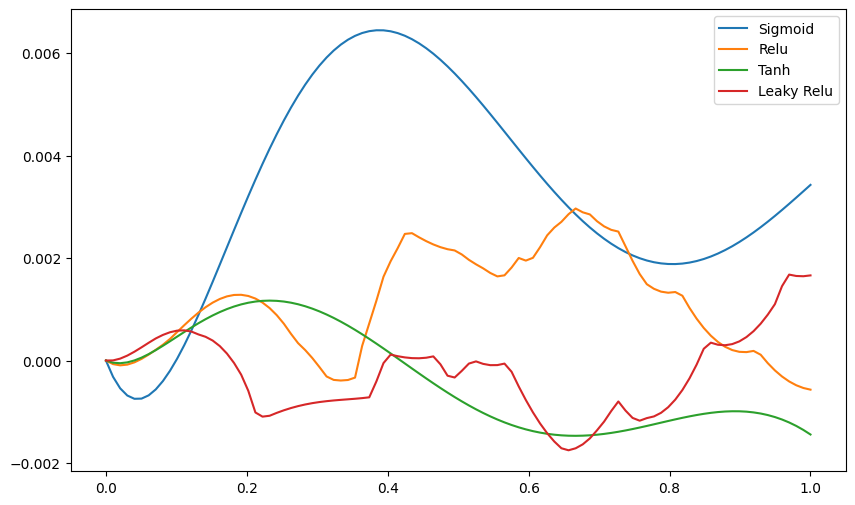

In [ ]:
fig, axis = plt.subplots(1,1, figsize = (10,6), sharex=True)

# Combine the plots in the second row into a single plot
axis.plot(x, y_original - y_exp1_sigm, label="Sigmoid")
axis.plot(x, y_original - y_exp1_relu, label="Relu")
axis.plot(x, y_original - y_exp1_tanh, label="Tanh")
axis.plot(x, y_original - y_exp1_leakyrelu, label="Leaky Relu")

axis.legend()


In [ ]:
# Trying same problem with lesser number of hidden neuron in single layer

In [ ]:
exp1_sigm_s = Network(1, hidden = 32)
exp1_relu_s = Network(1, hidden = 32, activation = "relu")
exp1_tanh_s = Network(1, hidden = 32, activation = "tanh")
exp1_leakyrelu_s = Network(1, hidden = 32, activation = "lrelu")

In [ ]:
train(exp1_sigm_s, first_order_loss, trial_solution, given_diff, 6001, 600)

epoch: 0, loss: 16.029294967651367
epoch: 600, loss: 2.446967840194702
epoch: 1200, loss: 0.12595804035663605
epoch: 1800, loss: 0.04280295968055725
epoch: 2400, loss: 0.036954157054424286
epoch: 3000, loss: 0.031030775979161263
epoch: 3600, loss: 0.02237248793244362
epoch: 4200, loss: 0.015383780933916569
epoch: 4800, loss: 0.013754511252045631
epoch: 5400, loss: 0.009612915106117725
epoch: 6000, loss: 0.008281017653644085


In [ ]:
lr = 0.0005
train(exp1_relu_s, first_order_loss, trial_solution, given_diff, 6001, 600)

epoch: 0, loss: 6.655784606933594
epoch: 600, loss: 0.04255066439509392
epoch: 1200, loss: 0.028361506760120392
epoch: 1800, loss: 0.024003110826015472
epoch: 2400, loss: 0.008217793889343739
epoch: 3000, loss: 0.003977030981332064
epoch: 3600, loss: 0.013100535608828068
epoch: 4200, loss: 0.00939924269914627
epoch: 4800, loss: 0.007693886291235685
epoch: 5400, loss: 0.006169843953102827
epoch: 6000, loss: 0.0070623974315822124


In [ ]:
lr = 0.005
train(exp1_tanh_s, first_order_loss, trial_solution, given_diff, 6001, 600)

epoch: 0, loss: 14.80379581451416
epoch: 600, loss: 0.009039303287863731
epoch: 1200, loss: 0.004777782596647739
epoch: 1800, loss: 0.004738119430840015
epoch: 2400, loss: 0.004093553870916367
epoch: 3000, loss: 0.0023531790357083082
epoch: 3600, loss: 0.002424425445497036
epoch: 4200, loss: 0.0015682914527133107
epoch: 4800, loss: 0.004781771916896105
epoch: 5400, loss: 0.00040743598947301507
epoch: 6000, loss: 0.0003113643906544894


In [ ]:
lr = 0.0005
train(exp1_leakyrelu_s, first_order_loss, trial_solution, given_diff, 6001, 600)

epoch: 0, loss: 17.336963653564453
epoch: 600, loss: 0.30544301867485046
epoch: 1200, loss: 0.017013413831591606
epoch: 1800, loss: 0.02211332879960537
epoch: 2400, loss: 0.007256024982780218
epoch: 3000, loss: 0.007605528924614191
epoch: 3600, loss: 0.008778857998549938
epoch: 4200, loss: 0.013249769806861877
epoch: 4800, loss: 0.009004016406834126
epoch: 5400, loss: 0.0036515300162136555
epoch: 6000, loss: 0.006669286638498306


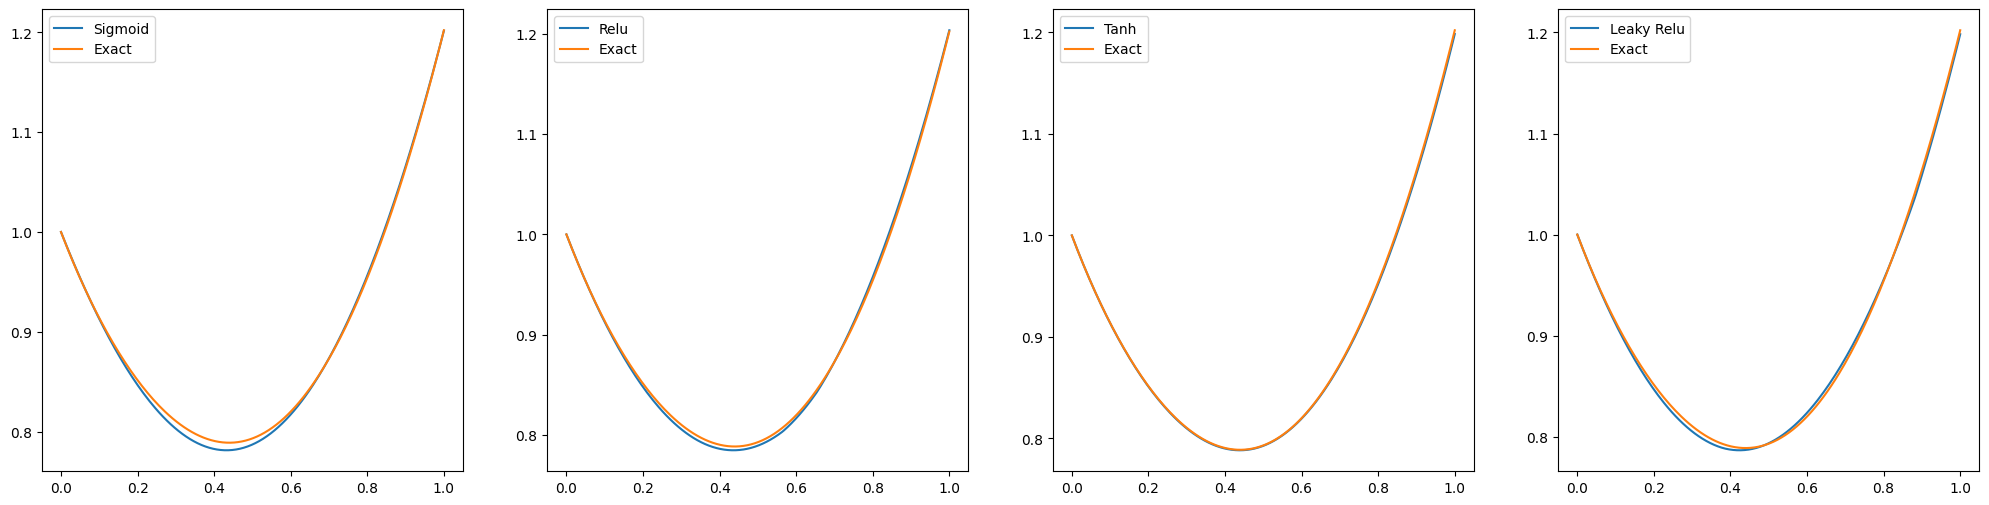

In [ ]:
x = torch.linspace(0, 1, 200).unsqueeze(1)
y_exp1_sigm_s = trial_solution(exp1_sigm_s, x).squeeze(0).detach().numpy().transpose()[0]
y_exp1_tanh_s = trial_solution(exp1_tanh_s, x).squeeze(0).detach().numpy().transpose()[0]
y_exp1_relu_s = trial_solution(exp1_relu_s, x).squeeze(0).detach().numpy().transpose()[0]
y_exp1_leakyrelu_s = trial_solution(exp1_leakyrelu_s, x).squeeze(0).detach().numpy().transpose()[0]

fig, axis = plt.subplots(1,4, figsize = (25,6), sharex=True)
y_original = original_function(x).squeeze(0).detach().numpy().transpose()[0]
x = x.squeeze(0).detach().numpy().transpose()[0]
axis[0].plot(x,y_exp1_sigm_s,  label = "Sigmoid")
axis[1].plot(x,y_exp1_relu_s,  label = "Relu")
axis[2].plot(x,y_exp1_tanh_s,  label = "Tanh")
axis[3].plot(x,y_exp1_leakyrelu_s,  label = "Leaky Relu")

for ax in axis:
    ax.plot(x, y_original, label="Exact")

# Add legends
for ax in axis:
    ax.legend()


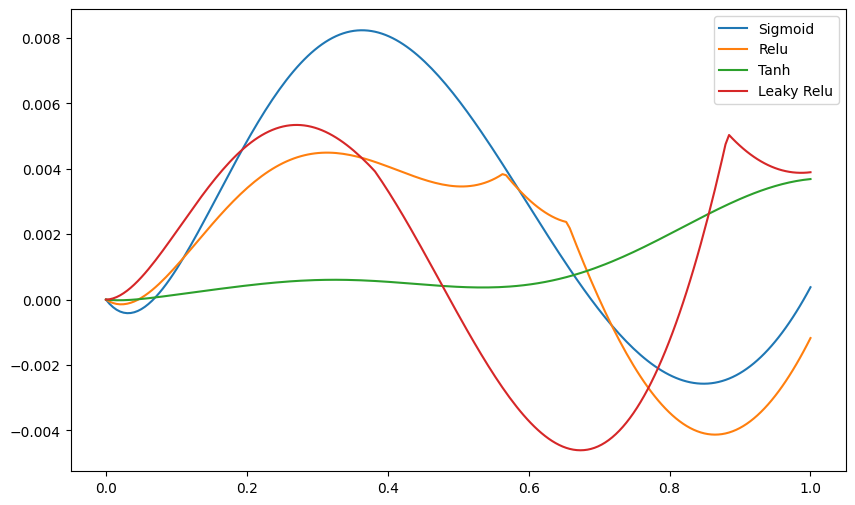

In [ ]:
fig, axis = plt.subplots(1,1, figsize = (10,6), sharex=True)

# Combine the plots in the second row into a single plot
axis.plot(x, y_original - y_exp1_sigm_s, label="Sigmoid")
axis.plot(x, y_original - y_exp1_relu_s, label="Relu")
axis.plot(x, y_original - y_exp1_tanh_s, label="Tanh")
axis.plot(x, y_original - y_exp1_leakyrelu_s, label="Leaky Relu")

axis.legend()


In [ ]:
# With less number of neuron in hidden layer tanh performs better while as number of neuron increases , leak relu start to overpower tanh

# Example 2

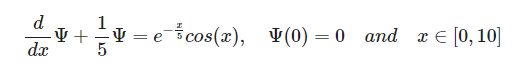


  
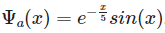

In [ ]:
def example2_trial_solution(neural_network, x):
    return x * neural_network(x)
def example2_given_diff(x, trial_solution, neural_network):
  return torch.exp(-x/5)*torch.cos(x) - trial_solution(neural_network, x)/5
def example2_function(x):
    return torch.exp(-x/5)*(torch.sin(x))

In [ ]:
exp2_sigm = Network(1, hidden = 128)
exp2_relu = Network(1, hidden = 128, activation = "relu")
exp2_tanh = Network(1, hidden = 128, activation = "tanh")
exp2_leakyrelu = Network(1, hidden = 128, activation = "lrelu")

In [ ]:
train(exp2_sigm, first_order_loss, example2_trial_solution, example2_given_diff, 2001, 200, domain_lower_bound=0, domain_upper_bound=2, num_points=20)

epoch: 0, loss: 8.28366470336914
epoch: 200, loss: 0.20589695870876312
epoch: 400, loss: 0.051760509610176086
epoch: 600, loss: 0.047891270369291306
epoch: 800, loss: 0.03780556097626686
epoch: 1000, loss: 0.030984774231910706
epoch: 1200, loss: 0.02595847100019455
epoch: 1400, loss: 0.020795438438653946
epoch: 1600, loss: 0.018723664805293083
epoch: 1800, loss: 0.014744018204510212
epoch: 2000, loss: 0.011177710257470608


In [ ]:
lr = 0.0003
train(exp2_tanh, first_order_loss, example2_trial_solution, example2_given_diff, 2001, 200, domain_lower_bound=0, domain_upper_bound=2, num_points=20)

epoch: 0, loss: 26.80301284790039
epoch: 200, loss: 0.1107824444770813
epoch: 400, loss: 0.04235139489173889
epoch: 600, loss: 0.013750636018812656
epoch: 800, loss: 0.0058924052864313126
epoch: 1000, loss: 0.0026135549414902925
epoch: 1200, loss: 0.001679762382991612
epoch: 1400, loss: 0.0008283458882942796
epoch: 1600, loss: 0.0017194818938151002
epoch: 1800, loss: 0.000966507475823164
epoch: 2000, loss: 0.001277018804103136


In [ ]:
lr = 0.0003
train(exp2_relu, first_order_loss, example2_trial_solution, example2_given_diff, 2001, 200, domain_lower_bound=0, domain_upper_bound=2, num_points=20)

epoch: 0, loss: 26.779756546020508
epoch: 200, loss: 0.9187206625938416
epoch: 400, loss: 0.062482960522174835
epoch: 600, loss: 0.038993142545223236
epoch: 800, loss: 0.02186134271323681
epoch: 1000, loss: 0.014415334910154343
epoch: 1200, loss: 0.0060844700783491135
epoch: 1400, loss: 0.005051217507570982
epoch: 1600, loss: 0.004117435775697231
epoch: 1800, loss: 0.002602741587907076
epoch: 2000, loss: 0.0019853233825415373


In [ ]:
lr = 0.0003
train(exp2_leakyrelu, first_order_loss, example2_trial_solution, example2_given_diff, 2001, 200, domain_lower_bound=0, domain_upper_bound=2, num_points=20)

epoch: 0, loss: 56.3294792175293
epoch: 200, loss: 2.252697706222534
epoch: 400, loss: 0.26195183396339417
epoch: 600, loss: 0.05532125383615494
epoch: 800, loss: 0.008285445161163807
epoch: 1000, loss: 0.005651960149407387
epoch: 1200, loss: 0.005147742573171854
epoch: 1400, loss: 0.003459909465163946
epoch: 1600, loss: 0.0027439971454441547
epoch: 1800, loss: 0.002340294886380434
epoch: 2000, loss: 0.002470486331731081


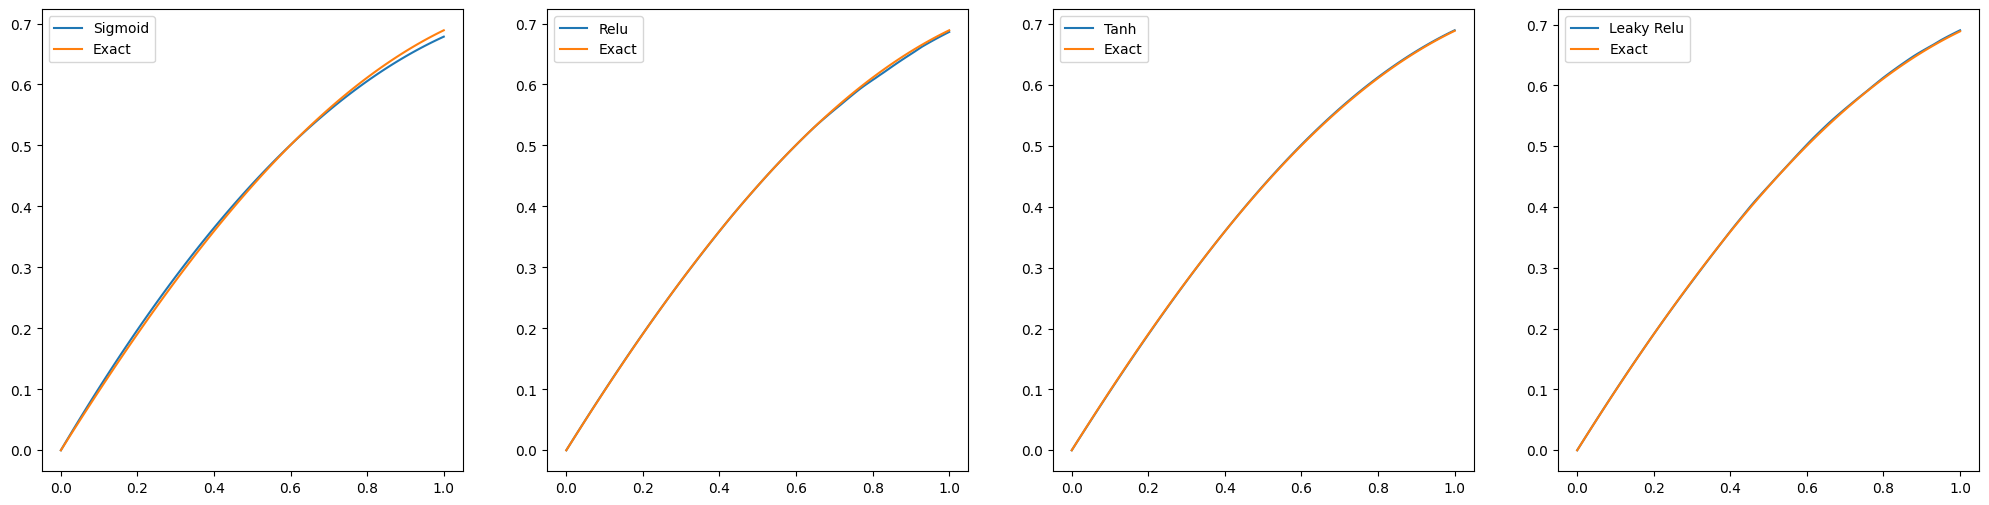

In [ ]:
x = torch.linspace(0, 1, 100).unsqueeze(1)
y_exp2_sigm = example2_trial_solution(exp2_sigm, x).squeeze(0).detach().numpy().transpose()[0]
y_exp2_tanh = example2_trial_solution(exp2_tanh, x).squeeze(0).detach().numpy().transpose()[0]
y_exp2_relu = example2_trial_solution(exp2_relu, x).squeeze(0).detach().numpy().transpose()[0]
y_exp2_leakyrelu = example2_trial_solution(exp2_leakyrelu, x).squeeze(0).detach().numpy().transpose()[0]

fig, axis = plt.subplots(1,4, figsize = (25,6), sharex=True)
y_exp2_original = example2_function(x).squeeze(0).detach().numpy().transpose()[0]
x = x.squeeze(0).detach().numpy().transpose()[0]
axis[0].plot(x,y_exp2_sigm,  label = "Sigmoid")
axis[1].plot(x,y_exp2_relu,  label = "Relu")
axis[2].plot(x,y_exp2_tanh,  label = "Tanh")
axis[3].plot(x,y_exp2_leakyrelu,  label = "Leaky Relu")

for ax in axis:
    ax.plot(x, y_exp2_original, label="Exact")

# Add legends
for ax in axis:
    ax.legend()


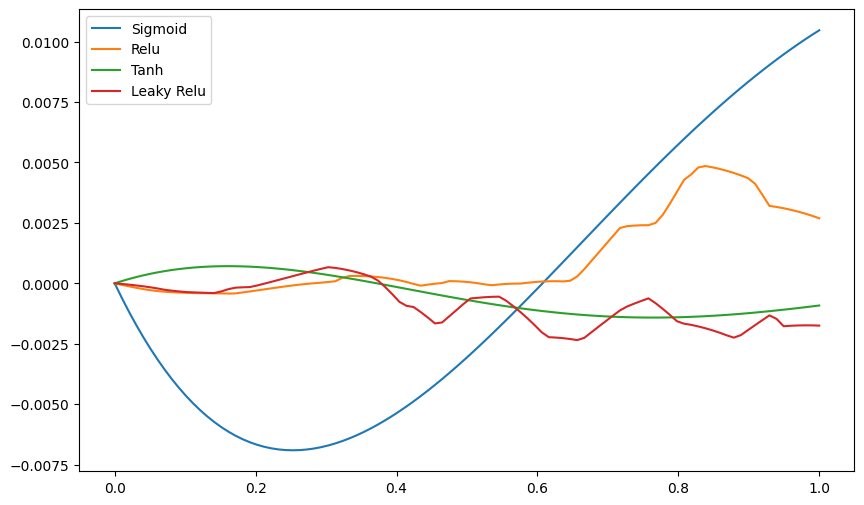

In [ ]:
fig, axis = plt.subplots(1,1, figsize = (10,6), sharex=True)

# Combine the plots in the second row into a single plot
axis.plot(x, y_exp2_original - y_exp2_sigm, label="Sigmoid")
axis.plot(x, y_exp2_original - y_exp2_relu, label="Relu")
axis.plot(x, y_exp2_original - y_exp2_tanh, label="Tanh")
axis.plot(x, y_exp2_original - y_exp2_leakyrelu, label="Leaky Relu")

axis.legend()


In [ ]:
exp2_sigm_s = Network(1, hidden = 32)
exp2_relu_s = Network(1, hidden = 32, activation = "relu")
exp2_tanh_s = Network(1, hidden = 32, activation = "tanh")
exp2_leakyrelu_s = Network(1, hidden = 32, activation = "lrelu")

In [ ]:
train(exp2_sigm_s, first_order_loss, example2_trial_solution, example2_given_diff, 2001, 200, domain_lower_bound=0, domain_upper_bound=2, num_points=20)

epoch: 0, loss: 19.359167098999023
epoch: 200, loss: 1.0289995670318604
epoch: 400, loss: 0.07291941344738007
epoch: 600, loss: 0.020288214087486267
epoch: 800, loss: 0.015215947292745113
epoch: 1000, loss: 0.013714215718209743
epoch: 1200, loss: 0.010560235008597374
epoch: 1400, loss: 0.007688350509852171
epoch: 1600, loss: 0.00809740461409092
epoch: 1800, loss: 0.005711551755666733
epoch: 2000, loss: 0.005477508530020714


In [ ]:
lr = 0.0005
train(exp2_tanh_s, first_order_loss, example2_trial_solution, example2_given_diff, 2001, 200, domain_lower_bound=0, domain_upper_bound=2, num_points=20)

epoch: 0, loss: 13.889301300048828
epoch: 200, loss: 0.4349815547466278
epoch: 400, loss: 0.004015143495053053
epoch: 600, loss: 0.0022560618817806244
epoch: 800, loss: 0.0012218093033879995
epoch: 1000, loss: 0.000932790688239038
epoch: 1200, loss: 0.0011595694813877344
epoch: 1400, loss: 0.0009258881327696145
epoch: 1600, loss: 0.0006525087519548833
epoch: 1800, loss: 0.0020110781770199537
epoch: 2000, loss: 0.0007796893478371203


In [ ]:
lr = 0.001
train(exp2_relu_s, first_order_loss, example2_trial_solution, example2_given_diff, 2001, 200, domain_lower_bound=0, domain_upper_bound=2, num_points=20)

epoch: 0, loss: 4.439276218414307
epoch: 200, loss: 0.02732398733496666
epoch: 400, loss: 0.025493063032627106
epoch: 600, loss: 0.019659344106912613
epoch: 800, loss: 0.007101152557879686
epoch: 1000, loss: 0.012098237872123718
epoch: 1200, loss: 0.008459480479359627
epoch: 1400, loss: 0.005377322901040316
epoch: 1600, loss: 0.00253671663813293
epoch: 1800, loss: 0.005240015219897032
epoch: 2000, loss: 0.0023532782215625048


In [ ]:
lr = 0.0005
train(exp2_leakyrelu_s, first_order_loss, example2_trial_solution, example2_given_diff, 2001, 200, domain_lower_bound=0, domain_upper_bound=2, num_points=20)

epoch: 0, loss: 6.592584133148193
epoch: 200, loss: 1.071014165878296
epoch: 400, loss: 0.08878884464502335
epoch: 600, loss: 0.013675441034138203
epoch: 800, loss: 0.004856238141655922
epoch: 1000, loss: 0.007789497263729572
epoch: 1200, loss: 0.007012955378741026
epoch: 1400, loss: 0.005938242189586163
epoch: 1600, loss: 0.006552788428962231
epoch: 1800, loss: 0.008371695876121521
epoch: 2000, loss: 0.006260815542191267


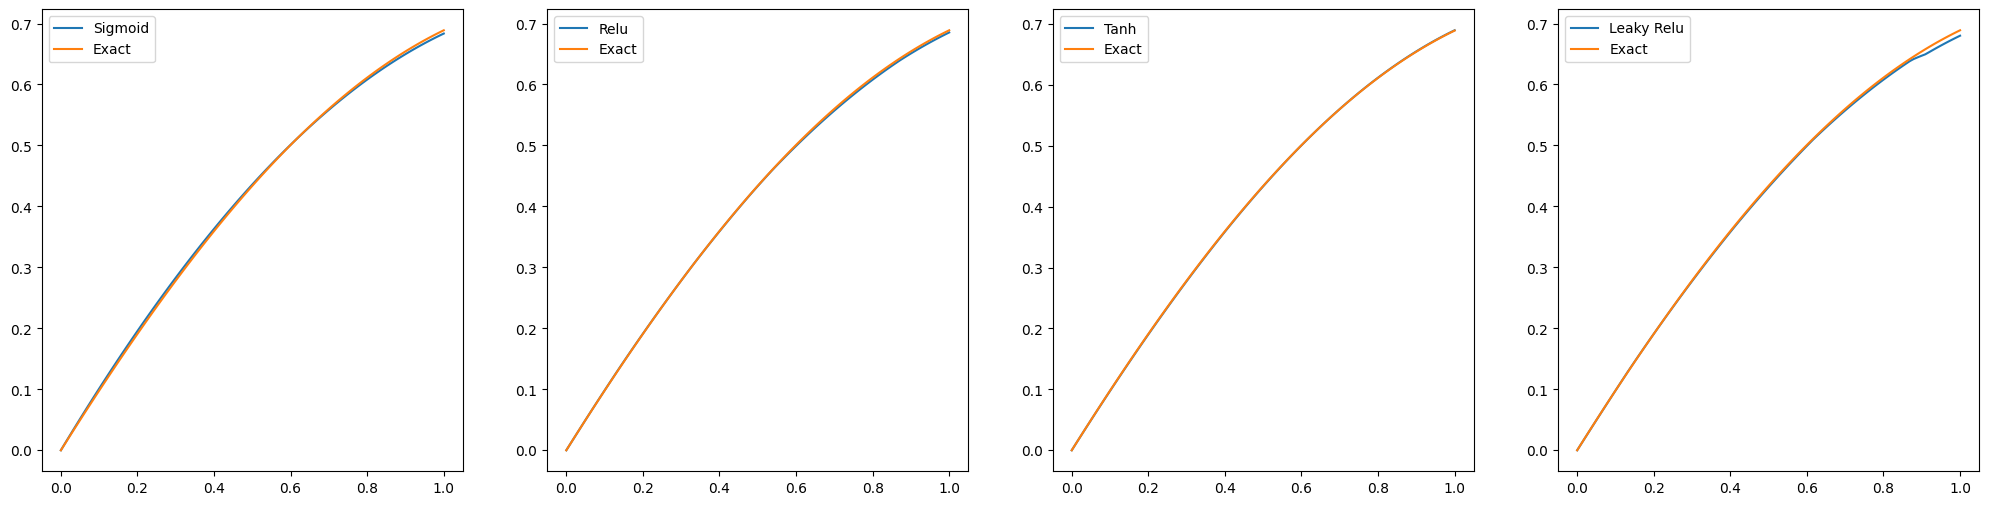

In [ ]:
x = torch.linspace(0, 1, 100).unsqueeze(1)
y_exp2_sigm_s = example2_trial_solution(exp2_sigm_s, x).squeeze(0).detach().numpy().transpose()[0]
y_exp2_tanh_s = example2_trial_solution(exp2_tanh_s, x).squeeze(0).detach().numpy().transpose()[0]
y_exp2_relu_s = example2_trial_solution(exp2_relu_s, x).squeeze(0).detach().numpy().transpose()[0]
y_exp2_leakyrelu_s = example2_trial_solution(exp2_leakyrelu_s, x).squeeze(0).detach().numpy().transpose()[0]

fig, axis = plt.subplots(1,4, figsize = (25,6), sharex=True)
y_exp2_original = example2_function(x).squeeze(0).detach().numpy().transpose()[0]
x = x.squeeze(0).detach().numpy().transpose()[0]
axis[0].plot(x,y_exp2_sigm_s,  label = "Sigmoid")
axis[1].plot(x,y_exp2_relu_s,  label = "Relu")
axis[2].plot(x,y_exp2_tanh_s,  label = "Tanh")
axis[3].plot(x,y_exp2_leakyrelu_s,  label = "Leaky Relu")

for ax in axis:
    ax.plot(x, y_exp2_original, label="Exact")

# Add legends
for ax in axis:
    ax.legend()


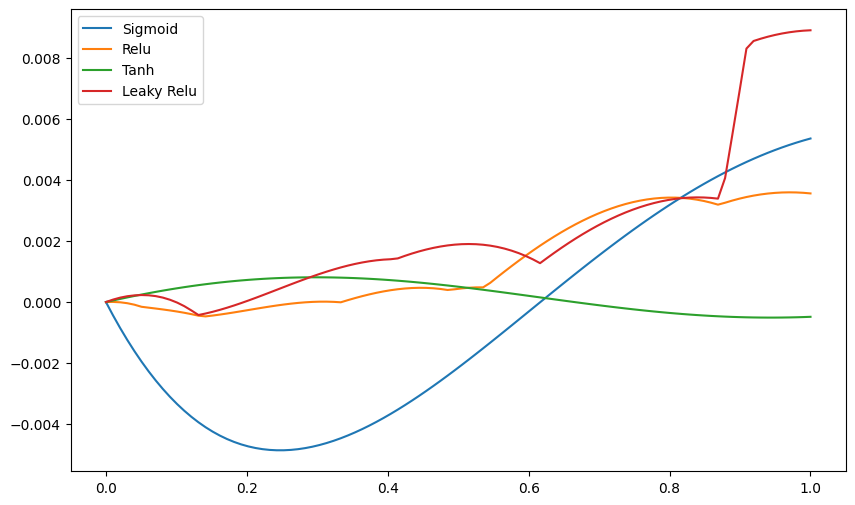

In [ ]:
fig, axis = plt.subplots(1,1, figsize = (10,6), sharex=True)

# Combine the plots in the second row into a single plot
axis.plot(x, y_exp2_original - y_exp2_sigm_s, label="Sigmoid")
axis.plot(x, y_exp2_original - y_exp2_relu_s, label="Relu")
axis.plot(x, y_exp2_original - y_exp2_tanh_s, label="Tanh")
axis.plot(x, y_exp2_original - y_exp2_leakyrelu_s, label="Leaky Relu")

axis.legend()


# Example 3

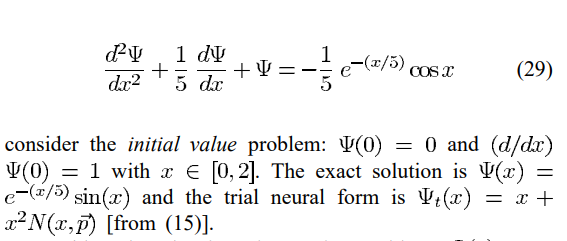

In [ ]:
lr = 0.005
def example3_trial_solution(neural_network, x):
    result = x + x*x*neural_network(x)
    return result
def example3_given_diff(x, dx, trial_solution, neural_network):
  return -(1.0/5.0)*torch.exp(-x/5)*torch.cos(x) - trial_solution(neural_network, x) - dx/5
def example3_function(x):
    return torch.exp(-x/5)*(torch.sin(x))

In [ ]:
example3 = Network(1, hidden = 32)

In [ ]:
train(example3, second_order_loss, example3_trial_solution, example3_given_diff, 2000, 200, domain_lower_bound=0, domain_upper_bound=2, num_points=20)

epoch: 0, loss: 0.2685445547103882
epoch: 200, loss: 0.0749252587556839
epoch: 400, loss: 0.10262646526098251
epoch: 600, loss: 0.10891656577587128
epoch: 800, loss: 0.15520721673965454
epoch: 1000, loss: 0.1299205720424652
epoch: 1200, loss: 0.19171497225761414
epoch: 1400, loss: 0.3658643364906311
epoch: 1600, loss: 0.1097182184457779
epoch: 1800, loss: 0.15280769765377045


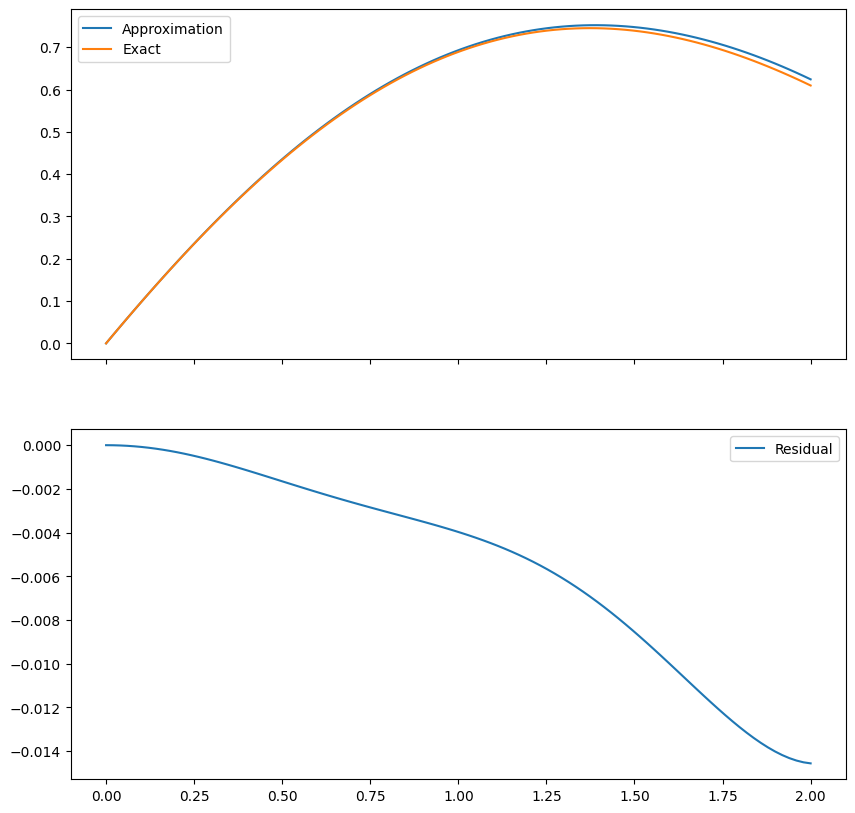

In [ ]:
visulaize(example3_trial_solution, example3, domain_lb = 0, domain_ub = 2, points = 100,original_fun = example3_function)

# Example 4
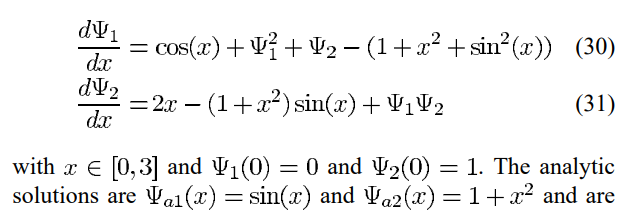

In [ ]:
def multi_var_loss(neural_network_1, neural_network_2,  domain_lower_bound=0, domain_upper_bound=1, num_points=10):
    def trial_solution_1(x):
      result = x*neural_network_1(x)
      return result
    def trial_solution_2(x):
      result = 1 + x*neural_network_2(x)
      return result
    delta = 1e-3
    x = torch.linspace(domain_lower_bound, domain_upper_bound, num_points, requires_grad=True).unsqueeze(1)
    dtrial_dx_1 = (trial_solution_1(x+delta) - trial_solution_1(x)) / delta
    dtrial_dx_2 = (trial_solution_2(x+delta) - trial_solution_2(x)) / delta
    individual_error_1 = (dtrial_dx_1 - torch.cos(x) - trial_solution_1(x)**2 - trial_solution_2(x) + 1 + x**2 + torch.sin(x)**2)**2
    individual_error_2 = (dtrial_dx_2 - 2*x - trial_solution_1(x)*trial_solution_2(x) + (1 + x*x)*torch.sin(x))**2


    return (torch.sum(individual_error_1) + torch.sum(individual_error_2))

In [ ]:
exmp4_1_relu = Network(1, hidden = 128, activation = "relu")
exmp4_2_relu = Network(1, hidden = 128, activation = "relu")

In [ ]:
exmp4_1_sigm = Network(1, hidden = 128, activation = "sigmoid")
exmp4_2_sigm = Network(1, hidden = 128, activation = "sigmoid")

In [ ]:
exmp4_1_tanh = Network(1, hidden = 128, activation = "tanh")
exmp4_2_tanh = Network(1, hidden = 128, activation = "tanh")

In [ ]:

optm1 = optim.Adam(exmp4_1_relu.parameters(), lr = 0.05 )
optm2 = optim.Adam(exmp4_2_relu.parameters(), lr = 0.05)

In [ ]:
for epoch in range(5000):
  # def closure():
  optm1.zero_grad()   # Clear gradients for the first model
  optm2.zero_grad()   # Clear gradients for the second model

  # Compute the loss
  loss = multi_var_loss(exmp4_1_relu, exmp4_2_relu, 0, 3, 100)

  # Backward pass
  loss.backward()
  if epoch % 500 == 0:
    print("epoch: {}, loss: {}".format(epoch, loss.item()))

  # return loss

  # Adjust model parameters accordingly
  optm1.step()
  optm2.step()



epoch: 0, loss: 2343.9755859375
epoch: 500, loss: 3.2042977809906006
epoch: 1000, loss: 0.8018568754196167
epoch: 1500, loss: 0.23612196743488312
epoch: 2000, loss: 0.25706249475479126
epoch: 2500, loss: 0.09834223985671997
epoch: 3000, loss: 0.2693330645561218
epoch: 3500, loss: 0.06139259785413742
epoch: 4000, loss: 0.09945029765367508
epoch: 4500, loss: 0.1254224330186844


In [ ]:
optm1 = optim.Adam(exmp4_1_tanh.parameters(), lr = 0.05 )
optm2 = optim.Adam(exmp4_2_tanh.parameters(), lr = 0.05)
for epoch in range(5000):
  # def closure():
  optm1.zero_grad()   # Clear gradients for the first model
  optm2.zero_grad()   # Clear gradients for the second model

  # Compute the loss
  loss = multi_var_loss(exmp4_1_tanh, exmp4_2_tanh, 0, 3, 100)

  # Backward pass
  loss.backward()
  if epoch % 500 == 0:
    print("epoch: {}, loss: {}".format(epoch, loss.item()))

  # return loss

  # Adjust model parameters accordingly
  optm1.step()
  optm2.step()



epoch: 0, loss: 2520.69482421875
epoch: 500, loss: 2.324251651763916
epoch: 1000, loss: 0.4780004024505615
epoch: 1500, loss: 0.20007574558258057
epoch: 2000, loss: 0.06915967911481857
epoch: 2500, loss: 0.019881483167409897
epoch: 3000, loss: 0.007323829457163811
epoch: 3500, loss: 0.004715279210358858
epoch: 4000, loss: 0.17436502873897552
epoch: 4500, loss: 0.01563500612974167


In [ ]:

optm1 = optim.Adam(exmp4_1_sigm.parameters(), lr = 0.03 )
optm2 = optim.Adam(exmp4_2_sigm.parameters(), lr = 0.03)
for epoch in range(5000):
  # def closure():
  optm1.zero_grad()   # Clear gradients for the first model
  optm2.zero_grad()   # Clear gradients for the second model

  # Compute the loss
  loss = multi_var_loss(exmp4_1_sigm, exmp4_2_sigm, 0, 3, 100)

  # Backward pass
  loss.backward()
  if epoch % 500 == 0:
    print("epoch: {}, loss: {}".format(epoch, loss.item()))

  # return loss

  # Adjust model parameters accordingly
  optm1.step()
  optm2.step()



epoch: 0, loss: 2567.33544921875
epoch: 500, loss: 9.184990882873535
epoch: 1000, loss: 1.9187088012695312
epoch: 1500, loss: 0.43470412492752075
epoch: 2000, loss: 0.16855351626873016
epoch: 2500, loss: 0.0975237563252449
epoch: 3000, loss: 0.26732656359672546
epoch: 3500, loss: 57.38112258911133
epoch: 4000, loss: 7.448915481567383
epoch: 4500, loss: 1.7527482509613037


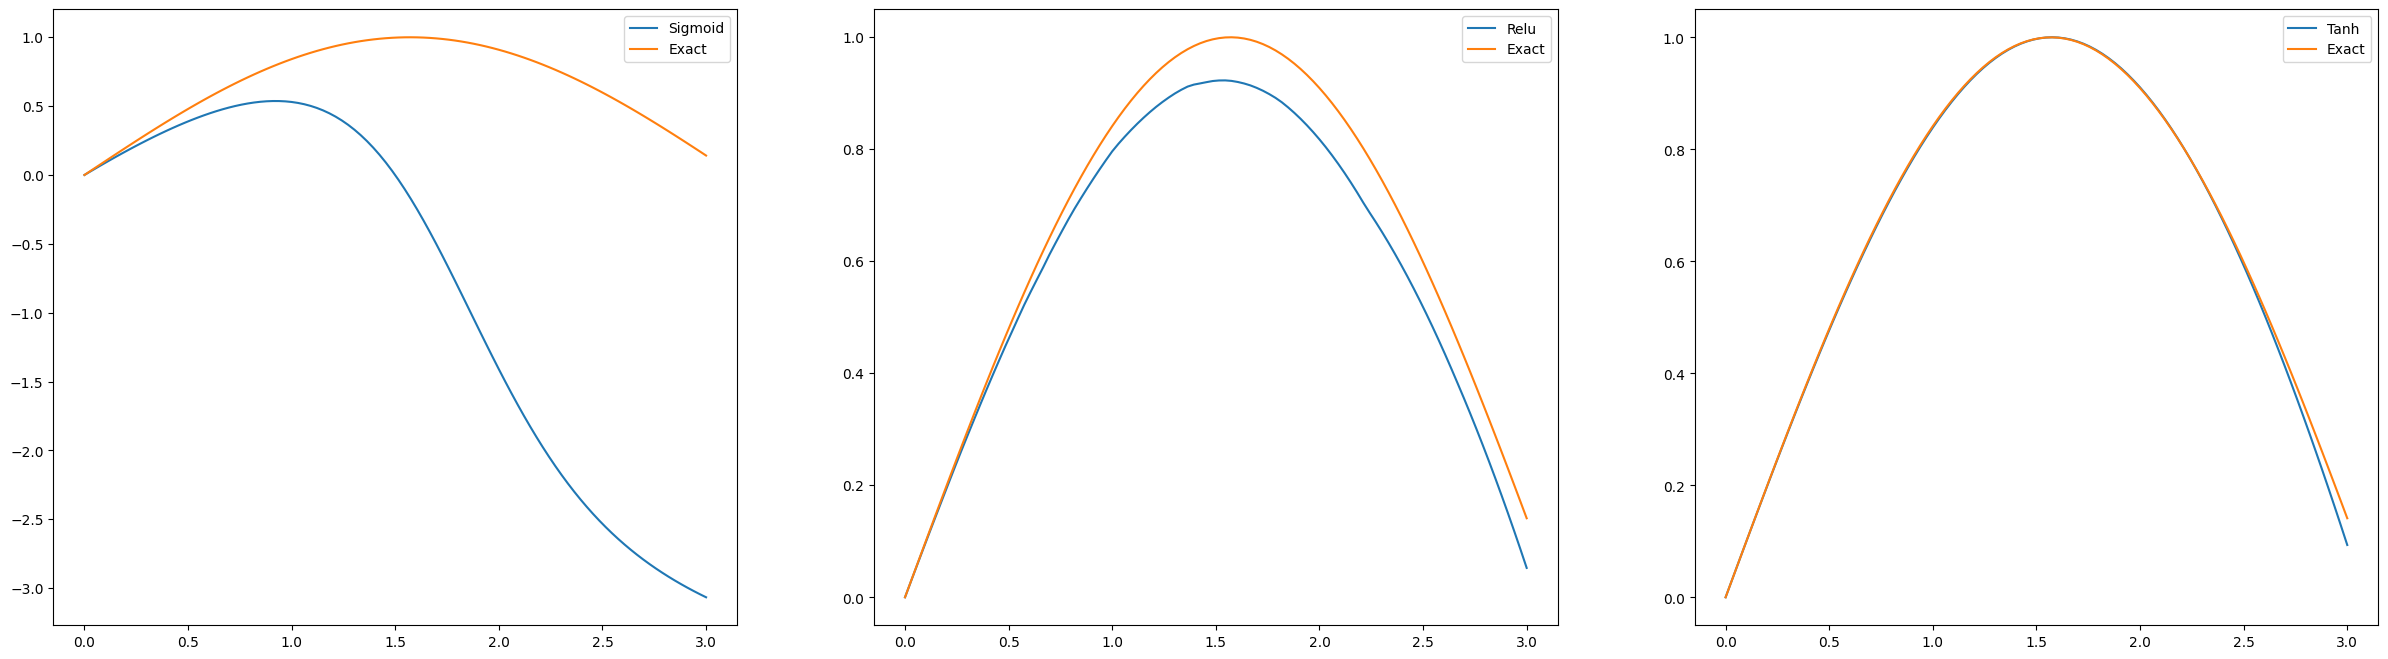

In [ ]:
x = torch.linspace(0, 3, 100).unsqueeze(1)
y_exp3_1_sigm = (x*exmp4_1_sigm(x)).squeeze(0).detach().numpy().transpose()[0]
y_exp3_1_relu = (x*exmp4_1_relu(x)).squeeze(0).detach().numpy().transpose()[0]
y_exp3_1_tanh = (x*exmp4_1_tanh(x)).squeeze(0).detach().numpy().transpose()[0]
y_original_1 = torch.sin(x).squeeze(0).detach().numpy().transpose()[0]
fig, axis = plt.subplots(1,3, figsize = (30,8), sharex=True)
x = x.squeeze(0).detach().numpy().transpose()[0]

axis[0].plot(x,y_exp3_1_sigm,  label = "Sigmoid")
axis[0].plot(x,y_original_1, label = "Exact")
axis[1].plot(x,y_exp3_1_relu,  label = "Relu")
axis[1].plot(x,y_original_1, label = "Exact")
axis[2].plot(x,y_exp3_1_tanh,  label = "Tanh")
axis[2].plot(x,y_original_1, label = "Exact")

axis[0].legend()
axis[1].legend()
axis[2].legend()

plt.show()

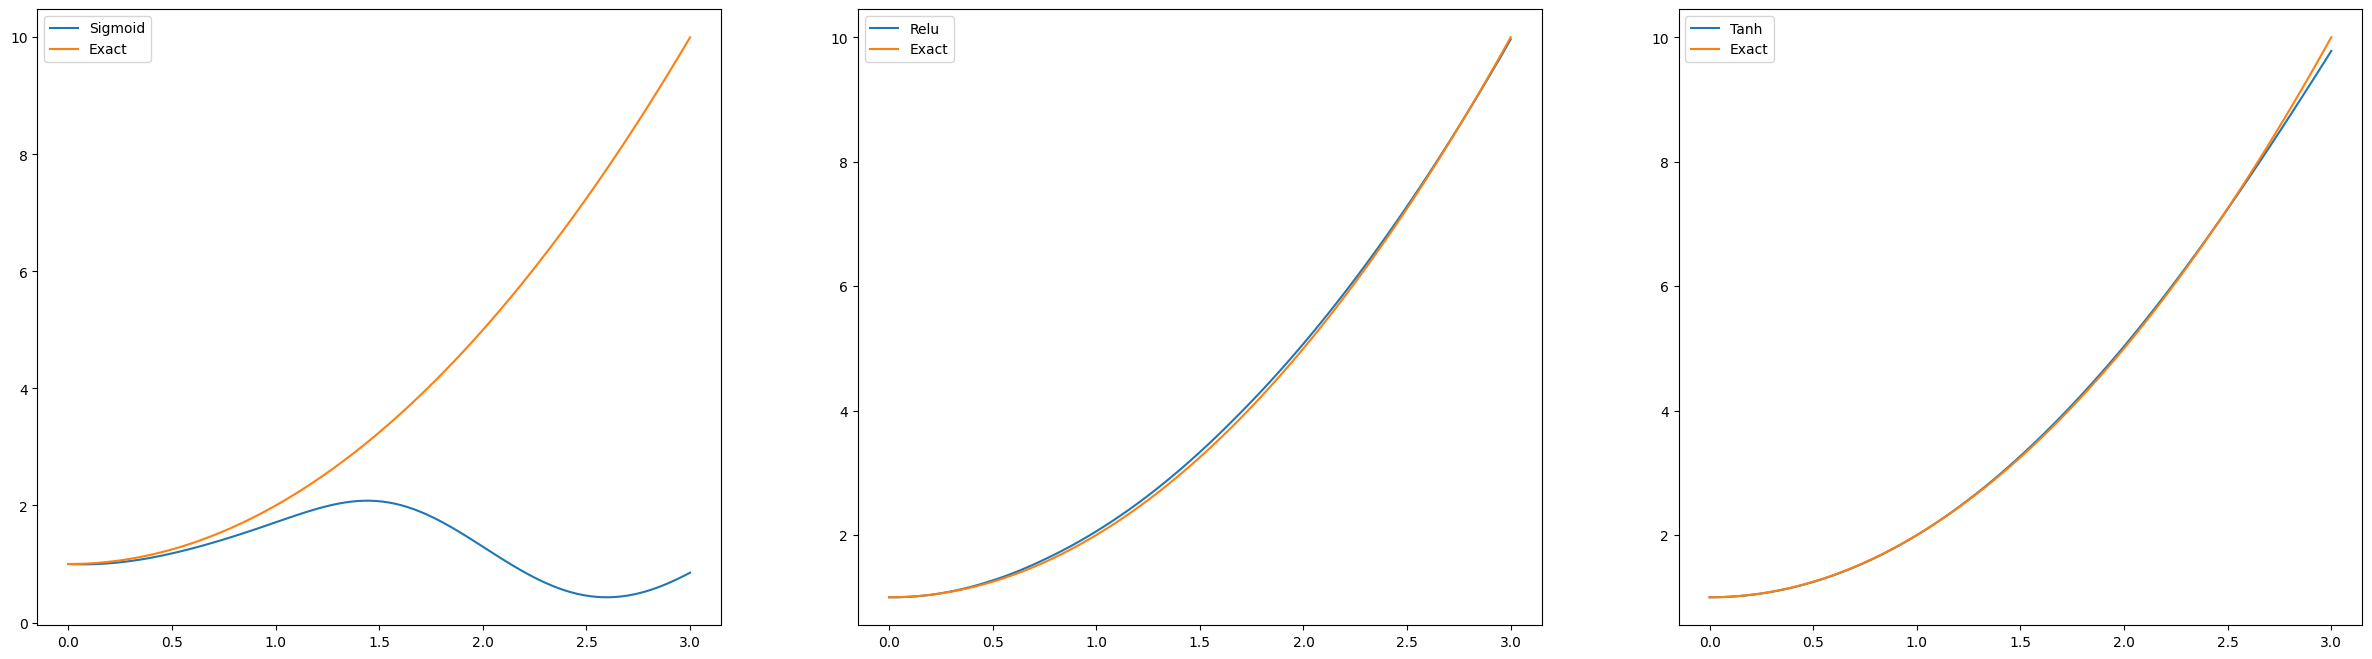

In [ ]:
x = torch.linspace(0, 3, 100).unsqueeze(1)
y_original_2 = (1 + x*x).squeeze(0).detach().numpy().transpose()[0]
y_exp3_2_sigm = (1 + x*exmp4_2_sigm(x)).squeeze(0).detach().numpy().transpose()[0]
y_exp3_2_relu = (1 + x*exmp4_2_relu(x)).squeeze(0).detach().numpy().transpose()[0]
y_exp3_2_tanh = (1 + x*exmp4_2_tanh(x)).squeeze(0).detach().numpy().transpose()[0]
fig, axis = plt.subplots(1,3, figsize = (30,8), sharex=True)
x = x.squeeze(0).detach().numpy().transpose()[0]

axis[0].plot(x,y_exp3_2_sigm,  label = "Sigmoid")
axis[0].plot(x,y_original_2, label = "Exact")
axis[1].plot(x,y_exp3_2_relu,  label = "Relu")
axis[1].plot(x,y_original_2, label = "Exact")
axis[2].plot(x,y_exp3_2_tanh,  label = "Tanh")
axis[2].plot(x,y_original_2, label = "Exact")

axis[0].legend()
axis[1].legend()
axis[2].legend()

plt.show()


In [ ]:
# PDE

In [ ]:
def pde_loss_1(nn,  domain_lower_bound=0, domain_upper_bound=1, num_points=10):
    def trial_solution(inp):
      x = inp[:, 0]
      y = inp[:, 1]
      result = (1-x)*(y**3) + x*(1+y**3)*torch.exp(torch.tensor(-1)) + (1-y)*x*(torch.exp(-x) - torch.exp(torch.tensor(-1))) + y*((1+x)*torch.exp(-x) - (1-x+2*x*torch.exp(torch.tensor(-1)))) + x*(1-x)*y*(1-y)*(nn(inp).squeeze())
      return result

    delta = 1e-3
    x = torch.linspace(0, 1, num_points, requires_grad = True)
    y = torch.linspace(0, 1, num_points, requires_grad = True)
    xy_pairs = torch.cartesian_prod(x, y)

    d2trial_dx = (trial_solution(torch.cartesian_prod(x + delta , y)) - 2*trial_solution(xy_pairs) + trial_solution(torch.cartesian_prod(x-delta, y)))/(delta**2)
    delta = 1e-3
    d2trial_dy = (trial_solution(torch.cartesian_prod(x , y + delta)) - 2*trial_solution(xy_pairs) + trial_solution(torch.cartesian_prod(x , y-delta)))/(delta**2)

    individual_error_1 = (d2trial_dx + d2trial_dy - (torch.exp(-xy_pairs[:, 0]))*(xy_pairs[:, 0] - 2 + xy_pairs[:, 1]**3 + 6*xy_pairs[:, 1]))**2

    return torch.sum(individual_error_1)

In [ ]:
pde1_sigm = Network(2, hidden = 64)
pde1_relu = Network(2, hidden = 64, activation = "relu")
pde1_tanh = Network(2, hidden = 64, activation= "tanh")

In [ ]:
lr = 0.005
optm1 = optim.Adam(pde1_sigm.parameters(), lr = lr)
for epoch in range(2001):
  # def closure():
  optm1.zero_grad()   # Clear gradients for the first model

  # Compute the loss
  loss = pde_loss_1(pde1_sigm, 0, 1, 10)

  # Backward pass
  loss.backward()
  if epoch % 500 == 0:
    print("epoch: {}, loss: {}".format(epoch, loss.item()))

  # Adjust model parameters accordingly
  optm1.step()


epoch: 0, loss: 26.869312286376953
epoch: 500, loss: 1.235392451286316
epoch: 1000, loss: 1.0137500762939453
epoch: 1500, loss: 0.8497362732887268
epoch: 2000, loss: 1.0593923330307007


In [ ]:
lr = 0.005
optm1 = optim.Adam(pde1_relu.parameters(), lr = lr)
for epoch in range(2001):
  # def closure():
  optm1.zero_grad()   # Clear gradients for the first model

  # Compute the loss
  loss = pde_loss_1(pde1_relu, 0, 1, 10)

  # Backward pass
  loss.backward()
  if epoch % 500 == 0:
    print("epoch: {}, loss: {}".format(epoch, loss.item()))

  # Adjust model parameters accordingly
  optm1.step()


epoch: 0, loss: 5.474550247192383
epoch: 500, loss: 0.9541735649108887
epoch: 1000, loss: 0.9791560769081116
epoch: 1500, loss: 1.016769528388977
epoch: 2000, loss: 1.0060153007507324


In [ ]:
lr = 0.005
optm1 = optim.Adam(pde1_tanh.parameters(), lr = lr)
for epoch in range(2001):
  # def closure():
  optm1.zero_grad()   # Clear gradients for the first model

  # Compute the loss
  loss = pde_loss_1(pde1_tanh, 0, 1, 10)

  # Backward pass
  loss.backward()
  if epoch % 500 == 0:
    print("epoch: {}, loss: {}".format(epoch, loss.item()))

  # Adjust model parameters accordingly
  optm1.step()


epoch: 0, loss: 8.015275955200195
epoch: 500, loss: 0.9162549376487732
epoch: 1000, loss: 0.9569640159606934
epoch: 1500, loss: 1.1894224882125854
epoch: 2000, loss: 0.9934235215187073


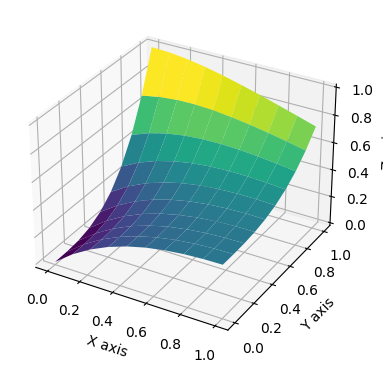

In [ ]:
x = np.linspace(0, 1, 10)
y = np.linspace(0, 1, 10)
x, y = np.meshgrid(x, y)

z = np.exp(-x)*((x + y**3))

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(131, projection='3d')
surf = ax.plot_surface(x, y, z, cmap='viridis')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()

In [ ]:
fig = make_subplots(
    rows=1, cols=3,
    specs=[[{'type': 'surface'}, {'type': 'surface'}, {'type': 'surface'}]],
    subplot_titles=('Sigmoid', 'Relu', 'Tanh')
)

xy_pairs = torch.tensor(np.column_stack([x.ravel(), y.ravel()]), dtype = torch.float32)

def trial_solution(inp, pde1):
    x = inp[:, 0]
    y = inp[:, 1]
    result = (1-x)*(y**3) + x*(1+y**3)*torch.exp(torch.tensor(-1)) + (1-y)*x*(torch.exp(-x) - torch.exp(torch.tensor(-1))) + y*((1+x)*torch.exp(-x) - (1-x + 2*x*torch.exp(torch.tensor(-1)))) + x*(1-x)*y*(1-y)*(pde1(inp).squeeze())
    return result

z1 = trial_solution(xy_pairs, pde1_sigm).detach().numpy().reshape(10,10)
z2 = trial_solution(xy_pairs, pde1_relu).detach().numpy().reshape(10,10)
z3 = trial_solution(xy_pairs, pde1_tanh).detach().numpy().reshape(10,10)

fig.add_trace(go.Surface(z=z1, x=x, y=y, colorscale='Viridis'), row=1, col=1)
fig.add_trace(go.Surface(z=z, x=x, y=y, colorscale='Cividis'), row=1, col=1)
fig.add_trace(go.Surface(z=z2, x=x, y=y, colorscale='Viridis'), row=1, col=2)
fig.add_trace(go.Surface(z=z, x=x, y=y, colorscale='Cividis'), row=1, col=2)
fig.add_trace(go.Surface(z=z3, x=x, y=y, colorscale='Viridis'), row=1, col=3)
fig.add_trace(go.Surface(z=z, x=x, y=y, colorscale='Cividis'), row=1, col=3)

# Update layout to include titles and adjust dimensions
fig.update_layout(
    title='Comparison of Two 3D Surfaces',
    width=1300,
    height=600,
)

# Update each subplot's axis titles
fig.update_scenes(
    dict(
        xaxis_title='X axis',
        yaxis_title='Y axis',
        zaxis_title='Z axis'
    ),
    row=1, col=1
)
fig.update_scenes(
    dict(
        xaxis_title='X axis',
        yaxis_title='Y axis',
        zaxis_title='Z axis'
    ),
    row=1, col=2
)
fig.update_scenes(
    dict(
        xaxis_title='X axis',
        yaxis_title='Y axis',
        zaxis_title='Z axis'
    ),
    row=1, col=3
)

# Show the figure
fig.show()

In [ ]:
fig = make_subplots(
    rows=1, cols=3,
    specs=[[{'type': 'surface'}, {'type': 'surface'}, {'type': 'surface'}]],
    subplot_titles=('Sigmoid', 'Relu', 'Tanh')
)

xy_pairs = torch.tensor(np.column_stack([x.ravel(), y.ravel()]), dtype = torch.float32)


fig.add_trace(go.Surface(z=z-z1, x=x, y=y, colorscale='Viridis'), row=1, col=1)
fig.add_trace(go.Surface(z=z - z2, x=x, y=y, colorscale='Viridis'), row=1, col=2)
fig.add_trace(go.Surface(z=z-z3, x=x, y=y, colorscale='Viridis'), row=1, col=3)

# Update layout to include titles and adjust dimensions
fig.update_layout(
    title='Comparison of Two 3D Surfaces',
    width=1300,
    height=600,
)

# Update each subplot's axis titles
fig.update_scenes(
    dict(
        xaxis_title='X axis',
        yaxis_title='Y axis',
        zaxis_title='Z axis'
    ),
    row=1, col=1
)
fig.update_scenes(
    dict(
        xaxis_title='X axis',
        yaxis_title='Y axis',
        zaxis_title='Z axis'
    ),
    row=1, col=2
)
fig.update_scenes(
    dict(
        xaxis_title='X axis',
        yaxis_title='Y axis',
        zaxis_title='Z axis'
    ),
    row=1, col=3
)

# Show the figure
fig.show()

In [ ]:
def pde_loss_2(nn,  domain_lower_bound=0, domain_upper_bound=1, num_points=10):
    def trial_solution(inp):
      x = inp[:, 0]
      y = inp[:, 1]
      dn = (nn(torch.stack([x, 1e-2 + torch.ones(x.shape)], axis = 1)) - nn(torch.stack([x, torch.ones(x.shape)], axis = 1)))/1e-2
      result =  y*(2*torch.sin(torch.pi*x)) + x*(1-x)*y*(nn(inp).squeeze() - nn(torch.stack([x, torch.ones(x.shape)], axis = 1)).squeeze() - dn.squeeze())
      return result

    delta = 1e-2
    # Create x and y values uniformly distributed between 0 and 1
    x = torch.linspace(0, 1, num_points, requires_grad = True)
    y = torch.linspace(0, 1, num_points, requires_grad = True)
    xy_pairs = torch.cartesian_prod(x, y)

    d2trial_dx = (trial_solution(torch.cartesian_prod(x + delta , y)) - 2*trial_solution(xy_pairs) + trial_solution(torch.cartesian_prod(x-delta, y)))/(delta**2)
    d2trial_dy = (trial_solution(torch.cartesian_prod(x , y + delta)) - 2*trial_solution(xy_pairs) + trial_solution(torch.cartesian_prod(x , y-delta)))/(delta**2)

    individual_error_1 = (d2trial_dx + d2trial_dy - (2-(torch.pi**2)*(xy_pairs[:, 1]**2))*(torch.sin(torch.pi*xy_pairs[:, 0])))**2

    return torch.sum(individual_error_1)

In [ ]:
pde2 = Network(2, hidden = 32)

In [ ]:
lr = 0.01
optm1 = optim.Adam(pde2.parameters(), lr = lr)
for epoch in range(20000):
  optm1.zero_grad()
  loss = pde_loss_2(pde2, 0, 1, 10)
  loss.backward()
  if epoch % 500 == 0:
    print("epoch: {}, loss: {}".format(epoch, loss.item()))
  optm1.step()


epoch: 0, loss: 9.081847190856934
epoch: 500, loss: 0.7641585469245911
epoch: 1000, loss: 0.9381282925605774
epoch: 1500, loss: 0.994135856628418
epoch: 2000, loss: 0.9010331630706787
epoch: 2500, loss: 1.262400507926941
epoch: 3000, loss: 0.4013855755329132
epoch: 3500, loss: 0.4162651002407074
epoch: 4000, loss: 0.22965693473815918
epoch: 4500, loss: 1.246509075164795
epoch: 5000, loss: 0.6021241545677185
epoch: 5500, loss: 1.6805273294448853
epoch: 6000, loss: 0.688488245010376
epoch: 6500, loss: 0.6223377585411072
epoch: 7000, loss: 0.5446923971176147
epoch: 7500, loss: 0.4976502060890198
epoch: 8000, loss: 0.7772232890129089
epoch: 8500, loss: 0.2933381497859955
epoch: 9000, loss: 1.221395492553711
epoch: 9500, loss: 0.45950978994369507
epoch: 10000, loss: 0.2648126780986786
epoch: 10500, loss: 0.26645809412002563
epoch: 11000, loss: 0.2916332185268402
epoch: 11500, loss: 0.7218204140663147
epoch: 12000, loss: 1.7654733657836914
epoch: 12500, loss: 0.5054442286491394
epoch: 13000,

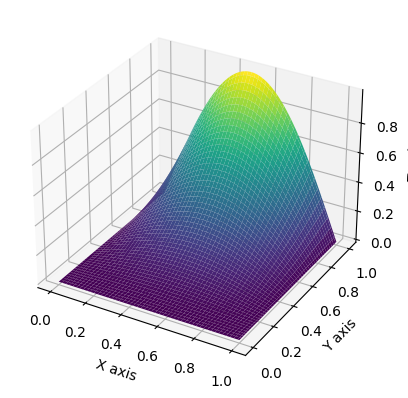

In [ ]:
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
x, y = np.meshgrid(x, y)
z = (y**2)*(np.sin(3.14*x))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, z, cmap='viridis')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()

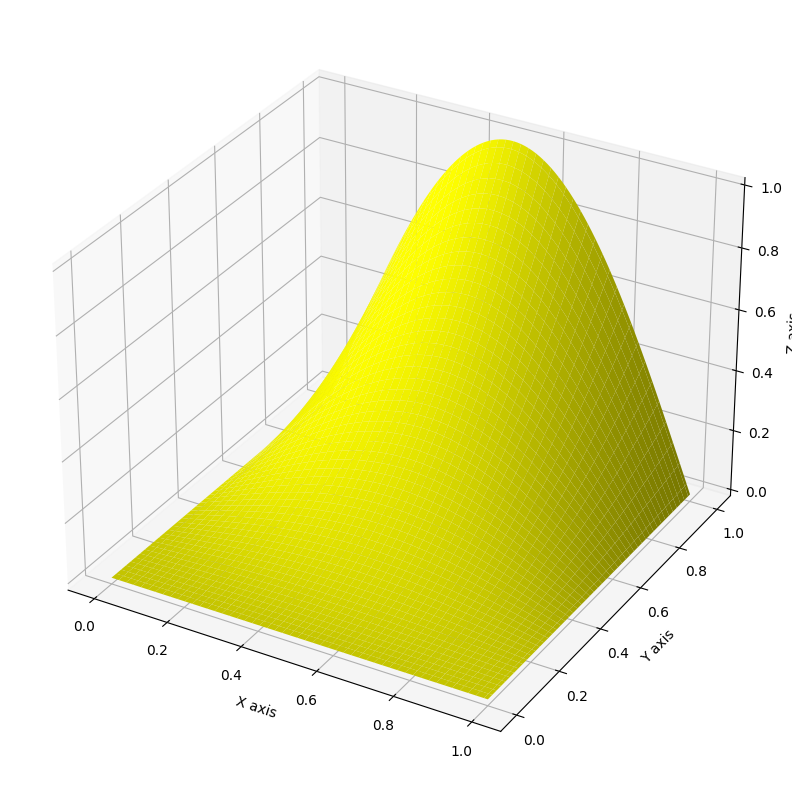

In [ ]:
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
x, y = np.meshgrid(x, y)
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
xy_pairs = torch.tensor(np.column_stack([x.ravel(), y.ravel()]), dtype = torch.float32)
def trial_solution_2(inp):
    x = inp[:, 0]
    y = inp[:, 1]
    dn = (pde2(torch.stack([x, 1e-2 + torch.ones(x.shape)], axis = 1)) - pde2(torch.stack([x, torch.ones(x.shape)], axis = 1)))/1e-2
    dn = dn.squeeze()
    result =  y*(2*torch.sin(3.14*x)) + x*(1-x)*y*(pde2(inp).squeeze() - pde2(torch.stack([x, torch.ones(x.shape)], axis = 1)).squeeze() - dn)
    return result

dz = trial_solution_2(xy_pairs).detach().numpy().reshape(100,100)
ax.plot_surface(x, y, dz, color='yellow')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()

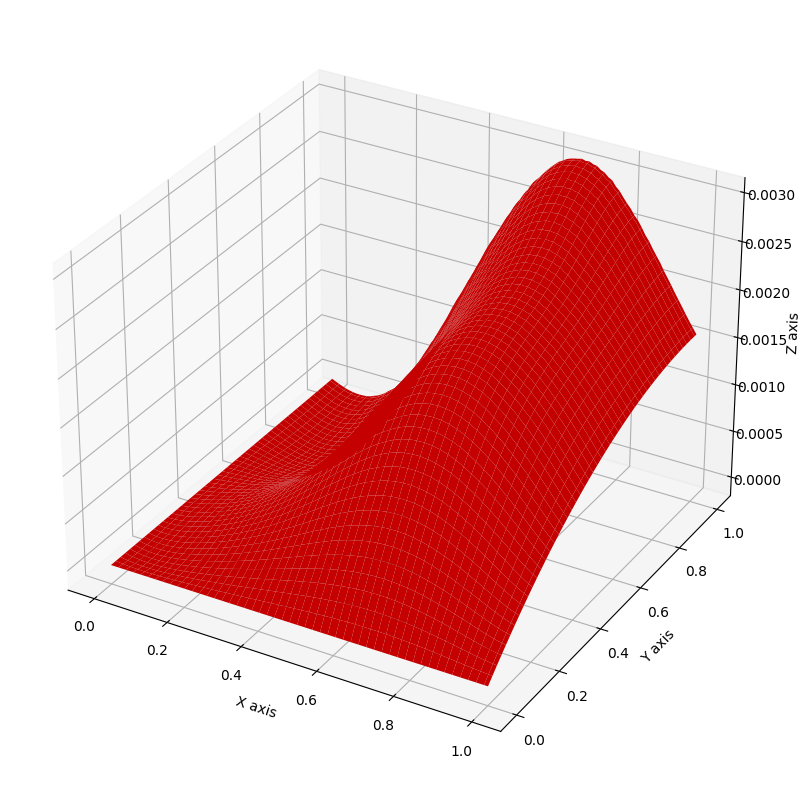

In [ ]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, dz - z, color='red')
# # Adding labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()

In [ ]:
def pde_loss_3(nn,  domain_lower_bound=0, domain_upper_bound=1, num_points=10):

    def trial_solution(inp):
      x = inp[:, 0]
      y = inp[:, 1]
      dn = (nn(torch.stack([x, 1e-2 + torch.ones(x.shape)], axis = 1)) - nn(torch.stack([x, torch.ones(x.shape)], axis = 1)))/1e-2
      result =  y*(2*torch.sin(3.14*x)) + x*(1-x)*y*(nn(inp).squeeze() - nn(torch.stack([x, torch.ones(x.shape)], axis = 1)).squeeze() - dn.squeeze())
      return result

    delta = 1e-2
    x = torch.linspace(0, 1, num_points, requires_grad = True)
    y = torch.linspace(0, 1, num_points, requires_grad = True)
    xy_pairs = torch.cartesian_prod(x, y)

    d2trial_dx = (trial_solution(torch.cartesian_prod(x + delta , y)) - 2*trial_solution(xy_pairs) + trial_solution(torch.cartesian_prod(x-delta, y)))/(delta**2)
    d2trial_dy = (trial_solution(torch.cartesian_prod(x , y + delta)) - 2*trial_solution(xy_pairs) + trial_solution(torch.cartesian_prod(x , y-delta)))/(delta**2)
    individual_error_1 = (d2trial_dx + d2trial_dy + trial_solution(xy_pairs)*(trial_solution(torch.cartesian_prod(x, y + delta)) - trial_solution(xy_pairs))/delta - torch.sin(3.14*xy_pairs[:, 0])*(2-(3.14*3.14)*(xy_pairs[:, 1]**2) + torch.sin(3.14*xy_pairs[:, 0])*2*(xy_pairs[:, 1]**3)))**2

    return torch.sum(individual_error_1)

In [ ]:
pde3 = Network(2, hidden = 32)

In [ ]:
lr = 0.01
optm1 = optim.Adam(pde3.parameters(), lr = lr)
for epoch in range(20000):
  optm1.zero_grad()
  loss = pde_loss_3(pde3, 0, 1, 10)
  loss.backward()
  if epoch % 500 == 0:
    print("epoch: {}, loss: {}".format(epoch, loss.item()))
  optm1.step()


epoch: 0, loss: 2665.117919921875
epoch: 500, loss: 9.370579719543457
epoch: 1000, loss: 3.2131805419921875
epoch: 1500, loss: 1.1301265954971313


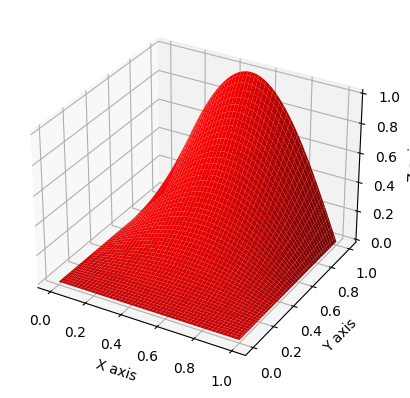

In [ ]:
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
x, y = np.meshgrid(x, y)
z = (y**2)*(np.sin(3.14*x))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xy_pairs = torch.tensor(np.column_stack([x.ravel(), y.ravel()]), dtype = torch.float32)
def trial_solution_3(inp):
    x = inp[:, 0]
    y = inp[:, 1]
    dn = (pde3(torch.stack([x, 1e-2 + torch.ones(x.shape)], axis = 1)) - pde3(torch.stack([x, torch.ones(x.shape)], axis = 1)))/1e-2
    dn = dn.squeeze()
    result =  y*(2*torch.sin(3.14*x)) + x*(1-x)*y*(pde3(inp).squeeze() - pde3(torch.stack([x, torch.ones(x.shape)], axis = 1)).squeeze() - dn)
    return result

dz = trial_solution_3(xy_pairs).detach().numpy().reshape(100,100)

ax.plot_surface(x, y, dz, color='red')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()

In [ ]:
import plotly.graph_objects as go

# fig = plt.figure(figsize = (10,10))
# ax = fig.add_subplot(111, projection='3d')
fig = go.Figure(data=[go.Surface(z=dz-z, x=x, y=y, colorscale='Viridis')])
fig.update_layout(
    scene=dict(
        xaxis_title='X axis',
        yaxis_title='Y axis',
        zaxis_title='Z axis'
    ),
    width=800,
    height=800,
)

fig.show()

# The End :) ✌